In [1]:
#danaderp May6'19
#Prediction For Main Issues Data Set

In [2]:
import csv
from tensorflow.keras.preprocessing import text
from nltk.corpus import gutenberg
from string import punctuation
from tensorflow.keras.preprocessing.sequence import skipgrams

/scratch/danaderp/.conda/envs/drmccr_conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

In [4]:
from nltk.stem.snowball import SnowballStemmer
englishStemmer=SnowballStemmer("english")

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dot, Input, Dense, Reshape, LSTM, Conv2D, Flatten, MaxPooling1D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Embedding, Multiply, Subtract
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

In [6]:
# visualize model structure
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE

In [7]:
from datasets.read_data import Dynamic_Dataset,Processing_Dataset
from vectorize_sentence import Embeddings

In [8]:
path = "datasets/combined_dataset/"
process_unit = Processing_Dataset(path)
ground_truth = process_unit.get_ground_truth()

In [9]:
dataset = Dynamic_Dataset(ground_truth, path)

In [10]:
test, train = process_unit.get_test_and_training(ground_truth)

In [11]:
print(len(test))
print(len(train))
print(test[0])
print(train[0])

1030
9308
('(1,0)', 'Per https://gitlab.com/gitlab-org/gitlab-ce/issues/40970#note_54045875\n\nCurrently, when a project is renamed or transferred, we introduce a redirect for the old project path. However, we allow someone to create a new project with the old path *immediately*. when this happens, the redirect is silently deleted.\n\nIt would be better to forbid the old path from being reused; either permanently (with an option for the project owner to release it), or for a fixed period of time (perhaps 30 days, perhaps with the option for the project owner to release it or make the reservation permanent).\n\nI *believe* namespace renames already reserve the old namespace path, but we should check, as this has the same problems.\n\nThis also happens to ameliorate a number of issue with Geo when running without hashed storage, as our scary races are to do with old project paths being reused.\n\n/cc @stanhu @jramsay')
('(1,0)', 'The currently used Rails version, in the stable branch, is

In [12]:
#Train/Test split verification
#for elem in test:
#    print(elem[0])

In [13]:
#Preprocesing Corpora
embeddings = Embeddings()
pre_corpora_train = [embeddings.preprocess(doc[1]) for doc in train]
pre_corpora_test = [embeddings.preprocess(doc[1]) for doc in test]

In [14]:
pre_corpora_train[0]

['current',
 'use',
 'rail',
 'version',
 'stabl',
 'branch',
 'insecur',
 'updat',
 'gemfil',
 'lock',
 'hotfix',
 'http',
 'weblog',
 'rubyonrail',
 'org',
 'rail',
 'beta',
 'releas']

In [15]:
max_len_sentences_train = max([len(doc) for doc in pre_corpora_train]) #<------- [Parameter]
max_len_sentences_test = max([len(doc) for doc in pre_corpora_test]) #<------- [Parameter]

In [16]:
max_len_sentences = max(max_len_sentences_train,max_len_sentences_test)
print("Max. Sentence # words:",max_len_sentences)

Max. Sentence # words: 13806


In [17]:
embed_path = 'datasets/word_embeddings-embed_size_100-epochs_100.csv'
embeddings_dict = embeddings.get_embeddings_dict(embed_path)

In [18]:
corpora_train = [embeddings.vectorize(doc[1], embeddings_dict) for doc in train]#vectorization Inputs
corpora_test = [embeddings.vectorize(doc[1], embeddings_dict) for doc in test]#vectorization

In [19]:
target_train = [[int(list(doc[0])[1]),int(list(doc[0])[3])] for doc in train]#vectorization Output
target_test = [[int(list(doc[0])[1]),int(list(doc[0])[3])]for doc in test]#vectorization Output
#target_train

In [20]:
max_len_sentences_train = max([len(doc) for doc in corpora_train]) #<------- [Parameter]
max_len_sentences_test = max([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [21]:
max_len_sentences = max(max_len_sentences_train,max_len_sentences_test)
print("Max. Sentence # words:",max_len_sentences)

Max. Sentence # words: 13789


In [22]:
embed_size = np.size(corpora_train[0][0])

In [23]:
#BaseLine Architecture <-------
embeddigs_cols = embed_size
input_sh = (max_len_sentences,embeddigs_cols,1)
#Selecting filters? 
#https://stackoverflow.com/questions/48243360/how-to-determine-the-filter-parameter-in-the-keras-conv2d-function
#https://stats.stackexchange.com/questions/196646/what-is-the-significance-of-the-number-of-convolution-filters-in-a-convolutional

N_filters = 128 # <-------- [HyperParameter] Powers of 2 Numer of Features
K = 2 # <-------- [HyperParameter] Number of Classess

In [24]:
input_sh

(13789, 100, 1)

In [25]:
#baseline_model = Sequential()
gram_input = Input(shape = input_sh)

In [26]:
# 1st Convolutional Layer (1-gram)
conv_filter_1_gram = Conv2D(filters= N_filters, input_shape=input_sh, activation='relu', 
                       kernel_size=(1,embeddigs_cols), padding='valid',data_format="channels_last")(gram_input)

In [27]:
# 2sd Convolutional Layer (3-gram)
conv_filter_3_gram = Conv2D(filters= N_filters, input_shape=input_sh, activation='relu', 
                       kernel_size=(3,embeddigs_cols), padding='valid')(gram_input)

In [28]:
# 3rd Convolutional Layer (5-gram)
conv_filter_5_gram = Conv2D(filters= N_filters, input_shape=input_sh, activation='relu', 
                       kernel_size=(5,embeddigs_cols), padding='valid')(gram_input)

In [29]:
# Max Pooling Layer
max_pool_1_gram = MaxPooling2D(pool_size=((max_len_sentences-1+1), 1), strides=None, padding='valid')(conv_filter_1_gram)
max_pool_3_gram = MaxPooling2D(pool_size=((max_len_sentences-3+1), 1), strides=None, padding='valid')(conv_filter_3_gram)
max_pool_5_gram = MaxPooling2D(pool_size=((max_len_sentences-5+1), 1), strides=None, padding='valid')(conv_filter_5_gram)

In [30]:
# Fully Connected layer
fully_connected_1_gram = Flatten()(max_pool_1_gram)
fully_connected_3_gram = Flatten()(max_pool_3_gram)
fully_connected_5_gram = Flatten()(max_pool_5_gram)

In [31]:
merged_vector = layers.concatenate([fully_connected_1_gram, fully_connected_3_gram, 
                                    fully_connected_5_gram], axis=-1)

integration_layer = Dropout(0.5)(merged_vector) # <-------- [HyperParameter]

In [32]:
#Extra Hidden Layer
deep_dense_layer = Dense(N_filters, activation='relu')(integration_layer)
deep_dense_layer = Dropout(0.5)(deep_dense_layer) # <-------- [HyperParameter]

In [33]:
predictions = Dense(K, activation='softmax')(deep_dense_layer)

In [34]:
#Criticality Model
criticality_network = Model(inputs=[gram_input],outputs=[predictions]) 

In [35]:
print(criticality_network.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13789, 100,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13789, 1, 128 12928       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 13787, 1, 128 38528       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 13785, 1, 128 64128       input_1[0][0]                    
______________________________________________________________________________________________

In [36]:
#Seting up the Model
criticality_network.compile(optimizer='adam',loss='binary_crossentropy',
                                  metrics=['accuracy'])

In [37]:
#Data set organization
from tempfile import mkdtemp
import os.path as path

In [38]:
#Memoization 
file_corpora_train_x = path.join(mkdtemp(), 'D-res_temp_corpora_train_x.dat') #Update per experiment
file_corpora_test_x = path.join(mkdtemp(), 'D-res_temp_corpora_test_x.dat')

In [39]:
#Shaping
shape_train_x = (len(corpora_train),max_len_sentences,embeddigs_cols,1)
shape_test_x = (len(corpora_test),max_len_sentences,embeddigs_cols,1)

In [40]:
#Data sets
corpora_train_x = np.memmap(
        filename = file_corpora_train_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_train_x)

In [41]:
corpora_test_x = np.memmap( #Test Corpora (for future evaluation)
        filename = file_corpora_test_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_test_x)

In [42]:
target_train_y = np.array(target_train) #Train Target
target_test_y = np.array(target_test) #Test Target (for future evaluation)

In [43]:
corpora_train_x.shape

(9308, 13789, 100, 1)

In [44]:
target_train_y.shape

(9308, 2)

In [45]:
corpora_test_x.shape

(1030, 13789, 100, 1)

In [46]:
target_test_y.shape

(1030, 2)

In [47]:
#Reshaping Train Inputs
for doc in range(len(corpora_train)):
    #print(corpora_train[doc].shape[1])
    for words_rows in range(corpora_train[doc].shape[0]):
        embed_flatten = np.array(corpora_train[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_train_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [48]:
#Reshaping Test Inputs (for future evaluation)
for doc in range(len(corpora_test)):
    for words_rows in range(corpora_test[doc].shape[0]):
        embed_flatten = np.array(corpora_test[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_test_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [49]:
#CheckPoints
#csv_logger = CSVLogger(system+'_training.log')
filepath = "D-res/embeds20-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath)
callbacks_list = [checkpoint]

In [50]:
#Model Fitting
history = criticality_network.fit(
            x = corpora_train_x, 
            y = target_train_y,
            #batch_size=64,
            epochs=20, #5 <------ Hyperparameter
            validation_split = 0.2,
            callbacks=callbacks_list
)

Train on 7446 samples, validate on 1862 samples
Epoch 1/20
7446/7446 [==============================] - 660s 89ms/sample - loss: 0.6233 - accuracy: 0.6679 - val_loss: 0.5394 - val_accuracy: 0.6912
Epoch 2/20
7446/7446 [==============================] - 653s 88ms/sample - loss: 0.5218 - accuracy: 0.7310 - val_loss: 0.4978 - val_accuracy: 0.7760
Epoch 3/20
7446/7446 [==============================] - 610s 82ms/sample - loss: 0.4738 - accuracy: 0.7679 - val_loss: 0.4903 - val_accuracy: 0.7615
Epoch 4/20
7446/7446 [==============================] - 593s 80ms/sample - loss: 0.4417 - accuracy: 0.7926 - val_loss: 0.5434 - val_accuracy: 0.6595
Epoch 5/20
7446/7446 [==============================] - 600s 81ms/sample - loss: 0.4154 - accuracy: 0.8116 - val_loss: 0.5630 - val_accuracy: 0.6890
Epoch 6/20
7446/7446 [==============================] - 599s 80ms/sample - loss: 0.3897 - accuracy: 0.8221 - val_loss: 0.6473 - val_accuracy: 0.6053
Epoch 7/20
7446/7446 [==============================] - 60

In [55]:
#Saving Training History
df_history = pd.DataFrame.from_dict(history.history)
df_history.to_csv('D-res/history_training.csv', encoding='utf-8',index=False)

In [56]:
df_history.head()

,accuracy,loss,val_accuracy,val_loss
0,0.667875,0.623308,0.691192,0.539365
1,0.730996,0.521766,0.776047,0.497774
2,0.767929,0.473771,0.761547,0.490331
3,0.792640,0.441698,0.659506,0.543433
4,0.811577,0.415417,0.689044,0.562996


In [57]:
#Saving Test Data
np.save('D-res/corpora_test_x.npy',corpora_test_x)
np.save('D-res/target_test_y.npy',target_test_y)

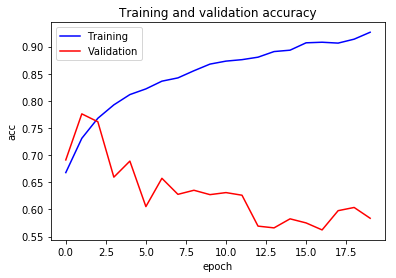

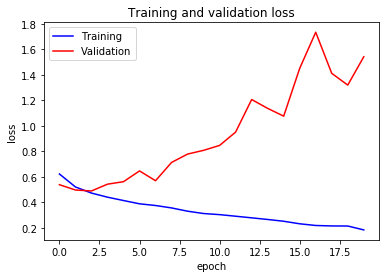

In [54]:
#Evaluation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs2 = range(len(acc))
 
plt.plot(epochs2, acc, 'b', label='Training')
plt.plot(epochs2, val_acc, 'r', label='Validation')
plt.title('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
 
plt.figure()
 
plt.plot(epochs2, loss, 'b', label='Training')
plt.plot(epochs2, val_loss, 'r', label='Validation')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
 
plt.show()